# Relevant Imports

In [1]:
import math
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from confeddi import FederatedSystem
from distribute_data import generate_data
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Preprocess Data

### Load RTT Data

In [2]:
data = pd.read_csv('RTT_data.csv')

# Getting rid of complex-valued columns
data = data.select_dtypes(exclude = ['object'])

# Quick look at data
print(f'Number of samples: {data.shape[0]}')
print(f'Features per sample: {data.shape[1] - 1}\n')
print(f'Columns:')
for i in data.columns[:-1]:
    if i == 'GroundTruthRange[m]':
        continue
    print(f'{i}, ', end = '')
print(data.columns[-1], end = '')


# Separate data and labels
X = data.drop(columns = ['GroundTruthRange[m]']).to_numpy()
y = data['GroundTruthRange[m]'].to_numpy()

Number of samples: 29581
Features per sample: 10

Columns:
%Timestamp[s], GroundTruthPositionX[m], GroundTruthPositionY[m], GroundTruthPositionZ[m], ML_range_estimate[m], AP_positionX[m], AP_positionY[m], AP_positionZ[m], AP_index, ToD_factor[m]

### Distribute data among clients

In [3]:
seed = 11

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = seed)

data = generate_data(X_train, y_train, seed = seed)
scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)
X = scaler.fit_transform(X)

fed = FederatedSystem(data['Client Data'], data['Client Labels'], data['Client Distances'])
fed.SetValData({'Val Data': X_val, 'Val Labels': y_val})
fed.SetTestData({'Data': X, 'Labels': y})

In [4]:
tf.keras.utils.set_random_seed(50)
tf.config.experimental.enable_op_determinism()
w, b = fed.FedAvg(rounds = 50)

Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50


In [5]:
fedavg_test_mse = fed.test_loss()
fedavg_val_mse = fed.val_loss()
fedavg_log = fed.GetLog()

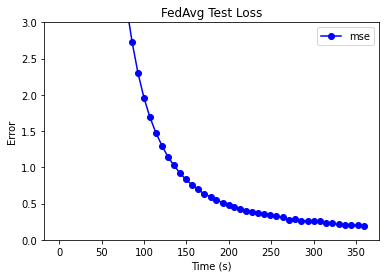

In [6]:
plt.plot(fedavg_log, fedavg_test_mse, color = 'blue', label = 'mse', marker = 'o')
plt.title(f'FedAvg Test Loss')
plt.ylabel('Error')
plt.xlabel('Time (s)')
plt.ylim(0, 3)
plt.legend()

In [7]:
np.save('history/important baselines/fedavg_test_mse.npy', fedavg_test_mse)
np.save('history/important baselines/fedavg_val_mse.npy', fedavg_val_mse)
np.save('history/important baselines/fedavg_log.npy', fedavg_log)

In [7]:
mse_losses[-1], mae_losses[-1]

(0.3382655084133148, 0.4143133759498596)

In [9]:
model = fed.generate_model(w, b)

In [10]:
model.predict(X)

925/925 [==============================] - 1s 939us/step


array([[30.590837],
       [22.610846],
       [26.429502],
       ...,
       [15.077161],
       [ 7.477501],
       [ 8.225125]], dtype=float32)

In [15]:
y[0]

31.047

In [16]:
y[1]

23.051

In [17]:
y[2]

26.095

In [18]:
y[-1]

6.9716

In [19]:
y[-2]

7.2991

In [20]:
y[-3]

13.833